# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).



# Applying Multinomial Naive Bayes

In [0]:
%matplotlib inline
import warnings
import pickle
warnings.filterwarnings("ignore")
import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
from sklearn.metrics import accuracy_score
#from sklearn import cross_validation
#from sklearn.cross_validation import cross_val_score
import seaborn as sn
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
import scipy.sparse
from scipy.sparse import find
from collections import Counter
import scikitplot.metrics as skplt
from prettytable import PrettyTable


Utility Function

In [0]:
def standardisation(mean,final_counts,final_counts_test):
  s = StandardScaler(with_mean = mean)
  standardized_data = s.fit_transform(final_counts)
  standardized_data_test = s.transform(final_counts_test)
  return (standardized_data,standardized_data_test)

def nb_classifier():
  alpha = [0.001,0.01,0.1,1,10,100,1000]
  tss = TimeSeriesSplit(n_splits=2)
  nb = MultinomialNB()
  parameter = {'alpha': alpha}
  clf = GridSearchCV(estimator = nb,param_grid = parameter,verbose = 1,scoring = 'roc_auc', cv=tss, n_jobs = 2)
  return clf

def train_set_report(clf):
  best_parameters = clf.best_params_
  best_accuracy = clf.best_score_
  print(best_parameters)
  print(best_accuracy)
  
def test_set_report(clf,x_test,y_test):
  pred = clf.predict(standardized_data_test)
  acc = accuracy_score(y_test, pred) * 100
  print('The test set accuracy is %f%%' %(acc))
  skplt.plot_confusion_matrix(y_test ,pred)
  print(classification_report(y_test ,pred))

def nbclassifierresults(clf):
  out = pd.DataFrame.from_dict(clf.cv_results_)
  return out


def plotGraph(a):
  b = a.param_alpha.tolist()
  c = a.mean_test_score.tolist()
  d = a.mean_train_score.tolist()
  plt.plot(b,c,color = 'blue',label = "Test Score")
  plt.plot(b,d,color = 'red', label = "Train Score")
  plt.title("Alpha and Score for Test and Cross validation")
  plt.xlabel("Alpha")
  plt.ylabel("Score")
  plt.legend()
  plt.show()
  
  
def roc_auc_curve(xtrain,ytrain,xtest,ytest):
  prob_train = clf.predict_proba(xtrain)
  fpr_train, tpr_train, threshold_train = metrics.roc_curve(ytrain, prob_train[:,-1])
  roc_auc_train = metrics.auc(fpr_train, tpr_train)
  prob_test = clf.predict_proba(xtest)
  fpr_test, tpr_test, threshold_test = metrics.roc_curve(ytest, prob_test[:,-1])
  roc_auc_test = metrics.auc(fpr_test, tpr_test)
  plt.title('Receiver Operating Characteristic')
  plt.plot(fpr_train, tpr_train,'b',color = 'green', label = 'Train AUC = %0.2f' % roc_auc_train)
  plt.plot(fpr_test, tpr_test, 'b', label = 'Test AUC = %0.2f' % roc_auc_test)
  plt.legend(loc = 'lower right')
  plt.plot([0, 1], [0, 1],'r--')
  plt.xlim([0, 1])
  plt.ylim([0, 1])
  plt.ylabel('True Positive Rate')
  plt.xlabel('False Positive Rate')
  plt.show()
  

  
 
  
  

  



**Data Sampling**

In [13]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
final = pd.read_pickle('/content/drive/My Drive/Dataset/AFR/final_100000.pkl')

In [15]:
final.shape

(100000, 12)

In [0]:
l = final['Score']
final = final.drop("Score", axis = 1)


In [17]:
def partition(x):
    if x == 'positive':
        return 1
    return 0
l1 = l.map(partition)
Counter(l1)

Counter({0: 12271, 1: 87729})

In [0]:
X_train, X_test, y_train, y_test = train_test_split(final, l1, test_size=0.3, random_state=0)

# BOW

In [19]:
import time
start_time = time.time()
count_vect = CountVectorizer()
final_counts = count_vect.fit_transform(X_train['CleanedText'].values)
print("--- %s seconds ---" % (time.time() - start_time))
print("the type of count vectorizer ",type(final_counts))
print("the shape of out text BOW vectorizer ",final_counts.get_shape())
print("the number of unique words ", final_counts.get_shape()[1])

--- 2.275024890899658 seconds ---
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (70000, 31572)
the number of unique words  31572


In [20]:
import time
start_time = time.time()
final_counts_test = count_vect.transform(X_test['CleanedText'].values)
print(final_counts.shape)
print(final_counts_test.shape)

(70000, 31572)
(30000, 31572)


In [0]:
standardized_data, standardized_data_test = standardisation(False,final_counts,final_counts_test)

In [0]:
bow_nb = nb_classifier()

In [0]:
bow_nb.fit(standardized_data, y_train)


Fitting 2 folds for each of 7 candidates, totalling 14 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  14 out of  14 | elapsed:    3.2s finished


GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=2),
       error_score='raise-deprecating',
       estimator=MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True),
       fit_params=None, iid='warn', n_jobs=2,
       param_grid={'alpha': [0.001, 0.01, 0.1, 1, 10, 100, 1000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=1)

In [0]:
with open('bow_nb_auc.pkl', 'wb') as f:
    pickle.dump(bow_nb, f)
uploadf('bow_nb_auc.pkl')

In [0]:
train_set_report(bow_nb)

{'alpha': 10}
0.7143355143406226


The test set accuracy is 84.350000%
              precision    recall  f1-score   support

           0       0.40      0.58      0.48      3665
           1       0.94      0.88      0.91     26335

   micro avg       0.84      0.84      0.84     30000
   macro avg       0.67      0.73      0.69     30000
weighted avg       0.87      0.84      0.86     30000



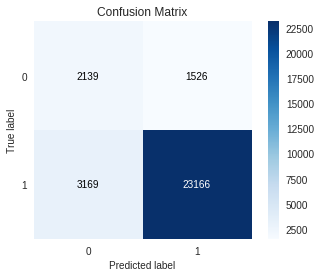

In [0]:
test_set_report(bow_nb,standardized_data_test,y_test)

In [0]:
out = nbclassifierresults(bow_nb)

In [0]:
out.head()

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_alpha,params,rank_test_score,split0_test_score,split0_train_score,split1_test_score,split1_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
0,0.084423,0.023949,0.689799,0.957859,0.001,{'alpha': 0.001},5,0.671945,0.966485,0.707652,0.949234,0.017172,0.000735,0.017854,0.008626
1,0.078685,0.023416,0.692177,0.957800,0.01,{'alpha': 0.01},4,0.674690,0.966401,0.709664,0.949198,0.023988,0.000610,0.017487,0.008601
2,0.080334,0.023023,0.695743,0.957558,0.1,{'alpha': 0.1},3,0.679572,0.966056,0.711915,0.949059,0.018653,0.000401,0.016171,0.008499
3,0.076192,0.023875,0.704967,0.956666,1,{'alpha': 1},2,0.691717,0.964744,0.718216,0.948587,0.017940,0.000624,0.013249,0.008078
4,0.072851,0.023404,0.714336,0.947806,10,{'alpha': 10},1,0.703459,0.953115,0.725212,0.942496,0.010230,0.000172,0.010877,0.005310


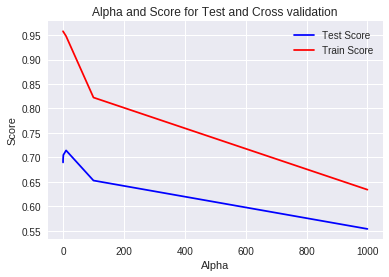

In [0]:
plotGraph(out)

In [23]:
clf = MultinomialNB(10)
clf.fit(standardized_data,y_train)

MultinomialNB(alpha=10, class_prior=None, fit_prior=True)

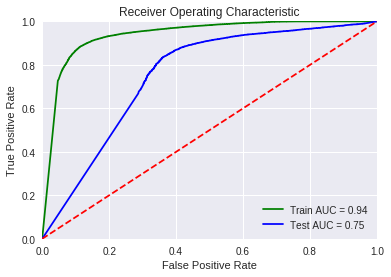

In [24]:
roc_auc_curve(standardized_data,y_train,standardized_data_test,y_test)

###  Top 10 important features of positive class from<font color='red'> SET 1</font>

In [32]:
#https://stackoverflow.com/questions/50526898/how-to-get-feature-importance-in-naive-bayes
for i in (np.take(count_vect.get_feature_names(),clf.feature_log_prob_[1, :].argsort()[:10])):
  print (i)


bogdon
trombon
csr
csnt
csirk
troglia
csc
oldfin
crystalis
olney


###  Top 10 important features of negative class from<font color='red'> SET 1</font>

In [33]:
for i in (np.take(count_vect.get_feature_names(),clf.feature_log_prob_[0, :].argsort()[:10])):
  print (i)

çay
humidor
sardinilla
sarni
humect
humdrum
humboldt
saronno
sarrano
humanitarian


## Applying Naive Bayes on TFIDF,<font color='red'> SET 2</font>

In [0]:
tf_idf_vect = TfidfVectorizer()
final_tf_idf = tf_idf_vect.fit_transform(X_train['CleanedText'].values)

In [36]:
#scipy.sparse.save_npz('tfidfsparse_matrix_100000.npz', final_counts)
print("type = ", type(final_tf_idf))
print("shape = ", final_tf_idf.get_shape())
print("number of unique words ", final_tf_idf.get_shape()[1])

type =  <class 'scipy.sparse.csr.csr_matrix'>
shape =  (70000, 31572)
number of unique words  31572


In [0]:
final_tf_idf_test = tf_idf_vect.transform(X_test['CleanedText'].values)

In [0]:
tfidf_nb = nb_classifier()

In [0]:
standardized_data, standardized_data_test = standardisation(False,final_tf_idf,final_tf_idf_test)

In [40]:
tfidf_nb.fit(standardized_data,y_train)

Fitting 2 folds for each of 7 candidates, totalling 14 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  14 out of  14 | elapsed:    3.0s finished


GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=2),
       error_score='raise-deprecating',
       estimator=MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True),
       fit_params=None, iid='warn', n_jobs=2,
       param_grid={'alpha': [0.001, 0.01, 0.1, 1, 10, 100, 1000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=1)

In [0]:
train_set_report(tfidf_nb)

{'alpha': 10}
0.7152086629897414


The test set accuracy is 83.936667%
              precision    recall  f1-score   support

           0       0.39      0.58      0.47      3665
           1       0.94      0.88      0.91     26335

   micro avg       0.84      0.84      0.84     30000
   macro avg       0.67      0.73      0.69     30000
weighted avg       0.87      0.84      0.85     30000



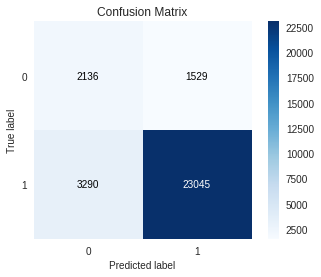

In [0]:
test_set_report(tfidf_nb,standardized_data_test,y_test)

In [0]:
with open('tfidf_nb_auc.pkl', 'wb') as f:
    pickle.dump(tfidf_nb, f)
uploadf('tfidf_nb_auc.pkl')

In [0]:
out = nbclassifierresults(tfidf_nb)

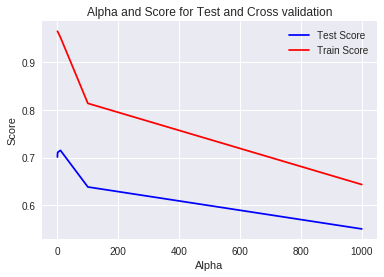

In [0]:
plotGraph(out)

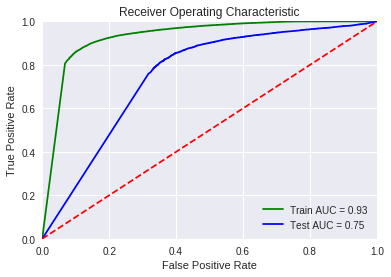

In [41]:
roc_auc_curve(standardized_data,y_train,standardized_data_test,y_test)

###  Top 10 important features of positive class from<font color='red'> SET 2</font>

In [42]:
for i in (np.take(tf_idf_vect.get_feature_names(),clf.feature_log_prob_[1, :].argsort()[:10])):
  print (i)

bogdon
trombon
csr
csnt
csirk
troglia
csc
oldfin
crystalis
olney


###  Top 10 important features of negative class from<font color='red'> SET 2</font>

In [44]:
for i in (np.take(tf_idf_vect.get_feature_names(),clf.feature_log_prob_[0, :].argsort()[:10])):
  print (i)

çay
humidor
sardinilla
sarni
humect
humdrum
humboldt
saronno
sarrano
humanitarian


# [6] Conclusions

In [0]:
x = PrettyTable()
x.field_names = ["VECTORIZER", "MODEL", "HYPERPARAMETER","AUC"]
x.add_row(["BOW", "MULTINOMIALNB", 10, .75])
x.add_row(["TFIDF", "MULTINOMIALNB", 10, .75])

In [50]:
print(x)

+------------+---------------+----------------+------+
| VECTORIZER |     MODEL     | HYPERPARAMETER | AUC  |
+------------+---------------+----------------+------+
|    BOW     | MULTINOMIALNB |       10       | 0.75 |
|   TFIDF    | MULTINOMIALNB |       10       | 0.75 |
+------------+---------------+----------------+------+
